In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# x_train_path = "/kaggle/input/wisdm-data/wisdm/x_train.npy"
# y_train_path = "/kaggle/input/wisdm-data/wisdm/y_train.npy"
x_train_path = "/root/HAR/dataset/PAMAP2/x_train.npy"
y_train_path = "/root/HAR/dataset/PAMAP2/y_train.npy"
# x_test_path = "/kaggle/input/wisdm-data/wisdm/x_test.npy"
# y_test_path = "/kaggle/input/wisdm-data/wisdm/y_test.npy"
x_test_path = "/root/HAR/dataset/PAMAP2/x_test.npy"
y_test_path = "/root/HAR/dataset/PAMAP2/y_test.npy"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y


class ChannelAttention1d(nn.Module):

    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention1d, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Conv1d(in_channels, in_channels//16, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv1d(in_channels//16, in_channels, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention1d(nn.Module):

    def __init__(self, kernel_size=3):
        super(SpatialAttention1d, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        if self.radix > 1:
            batch = x.size(0)
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x


class DropBlock1D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError


class SplAtConv1d(nn.Module):
    def __init__(
            self,
            in_channels,
            channels,
            kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=True,
            radix=2,
            reduction_factor=4,
            norm_layer=None,
            dropblock_prob=0.0,
            **kwargs,

    ):
        super().__init__()

        self.dropblock_prob = dropblock_prob
        inter_channels = max(in_channels * radix // reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels

        self.conv = nn.Conv1d(
            in_channels,
            channels * radix,
            kernel_size,
            stride,
            padding,
            dilation,
            groups=groups * radix,
            bias=bias,
            **kwargs,
        )
        self.bn0 = norm_layer(self.channels * radix)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Conv1d(self.channels, inter_channels, 1, groups=self.cardinality)
        self.bn1 = norm_layer(inter_channels)
        self.fc2 = nn.Conv1d(inter_channels, self.channels * radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock1D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, self.cardinality)
        self.se = SEModule(in_channels)
        self.ca1 = ChannelAttention1d(in_channels)
        self.sa1 = SpatialAttention1d()

    def forward(self, x):
        #x = self.ca1(x) * x
        #x=  self.sa1(x) * x
        #x = self.se(x) * x
        x = self.conv(x)
        x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, int(rchannel // self.radix), dim=1)
            gap = sum(splited)
        else:
            gap = x
        #se放在这个位置结果非常好
        #位置1，通道注意力
        gap = self.ca1(gap) * gap
        #gap = self.sa1(gap) * gap
        #gap = self.se(gap) * gap
        gap = F.adaptive_avg_pool1d(gap, 1)
        gap = self.fc1(gap)
        gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1)

        if self.radix > 1:
            attens = torch.split(atten, int(rchannel // self.radix), dim=1)
            outs = []
            for att, split in zip(attens, splited):
                outs.append(att * split)
            out = sum(outs)
        else:
            out = atten * x
       # out = self.se(out) * out
        #out = self.ca1(out) * out
        #out = self.sa1(out) * out
        return out.contiguous()





class ResNeStBottleneck(nn.Module):
    expansion = 4

    def __init__(
            self,
            inplanes,
            planes,
            stride=1,
            downsample=None,
            radix=1,
            cardinality=1,
            bottleneck_width=64,
            avd=False,
            avd_first=False,
            dilation=1,
            is_first=False,
            norm_layer=None,
            last_gamma=False,
            dropblock_prob=0.0
    ):
        super().__init__()
        group_width = int(planes * (bottleneck_width / 64.0)) * cardinality

        self.conv1 = nn.Conv1d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first
        self.dropblock_prob = dropblock_prob

        if self.avd:
            self.avd_layer = nn.AvgPool1d(3, stride, padding=1)
            stride = 1
        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock1D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock1D(dropblock_prob, 3)
            self.dropblock3 = DropBlock1D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
                radix=radix,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob
            )
        else:
            self.conv2 = nn.Conv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
            )
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv1d(group_width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        if last_gamma:
            from torch.nn.init import zeros_

            zeros_(self.bn3.weight)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride
        self.ca1 = ChannelAttention1d(group_width)
        self.sa1 = SpatialAttention1d()

        self.se = SEModule(group_width)
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #x = self.ca1(x) * x
        #位置2，空间注意力
       
        out = self.sa1(out) * out
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)
        if self.avd and self.avd_first:
            out = self.avd_layer(out)
        #out = self.ca1(out) * out
        #out=  self.sa1(out) * out
        #out = self.se(out) * out
        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out


In [4]:
class SplAtConv1d_WithoutCA(nn.Module):
    def __init__(
            self,
            in_channels,
            channels,
            kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=True,
            radix=2,
            reduction_factor=4,
            norm_layer=None,
            dropblock_prob=0.0,
            **kwargs,

    ):
        super().__init__()

        self.dropblock_prob = dropblock_prob
        inter_channels = max(in_channels * radix // reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels

        self.conv = nn.Conv1d(
            in_channels,
            channels * radix,
            kernel_size,
            stride,
            padding,
            dilation,
            groups=groups * radix,
            bias=bias,
            **kwargs,
        )
        self.bn0 = norm_layer(self.channels * radix)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Conv1d(self.channels, inter_channels, 1, groups=self.cardinality)
        self.bn1 = norm_layer(inter_channels)
        self.fc2 = nn.Conv1d(inter_channels, self.channels * radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock1D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, self.cardinality)
        self.se = SEModule(in_channels)
        self.ca1 = ChannelAttention1d(in_channels)
        self.sa1 = SpatialAttention1d()

    def forward(self, x):
        #x = self.ca1(x) * x
        #x=  self.sa1(x) * x
        #x = self.se(x) * x
        x = self.conv(x)
        x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, int(rchannel // self.radix), dim=1)
            gap = sum(splited)
        else:
            gap = x
        #se放在这个位置结果非常好
        #位置1，通道注意力
        #gap = self.ca1(gap) * gap
        #gap = self.sa1(gap) * gap
        #gap = self.se(gap) * gap
        gap = F.adaptive_avg_pool1d(gap, 1)
        gap = self.fc1(gap)
        gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1)

        if self.radix > 1:
            attens = torch.split(atten, int(rchannel // self.radix), dim=1)
            outs = []
            for att, split in zip(attens, splited):
                outs.append(att * split)
            out = sum(outs)
        else:
            out = atten * x
       # out = self.se(out) * out
        #out = self.ca1(out) * out
        #out = self.sa1(out) * out
        return out.contiguous()
    
class ResNeStBottleneck_WithoutCA(nn.Module):
    expansion = 4

    def __init__(
            self,
            inplanes,
            planes,
            stride=1,
            downsample=None,
            radix=1,
            cardinality=1,
            bottleneck_width=64,
            avd=False,
            avd_first=False,
            dilation=1,
            is_first=False,
            norm_layer=None,
            last_gamma=False,
            dropblock_prob=0.0
    ):
        super().__init__()
        group_width = int(planes * (bottleneck_width / 64.0)) * cardinality

        self.conv1 = nn.Conv1d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first
        self.dropblock_prob = dropblock_prob

        if self.avd:
            self.avd_layer = nn.AvgPool1d(3, stride, padding=1)
            stride = 1
        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock1D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock1D(dropblock_prob, 3)
            self.dropblock3 = DropBlock1D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv1d_WithoutCA(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
                radix=radix,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob
            )
        else:
            self.conv2 = nn.Conv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
            )
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv1d(group_width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        if last_gamma:
            from torch.nn.init import zeros_

            zeros_(self.bn3.weight)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride
        self.ca1 = ChannelAttention1d(group_width)
        self.sa1 = SpatialAttention1d()

        self.se = SEModule(group_width)
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #x = self.ca1(x) * x
        #位置2，空间注意力
        #x=  self.sa1(x) * x
        out = self.sa1(out) * out
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)
        if self.avd and self.avd_first:
            out = self.avd_layer(out)
        #out = self.ca1(out) * out
        #out=  self.sa1(out) * out
        #out = self.se(out) * out
        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out

class ResNeStBottleneck_WithoutSA(nn.Module):
    expansion = 4

    def __init__(
            self,
            inplanes,
            planes,
            stride=1,
            downsample=None,
            radix=1,
            cardinality=1,
            bottleneck_width=64,
            avd=False,
            avd_first=False,
            dilation=1,
            is_first=False,
            norm_layer=None,
            last_gamma=False,
            dropblock_prob=0.0
    ):
        super().__init__()
        group_width = int(planes * (bottleneck_width / 64.0)) * cardinality

        self.conv1 = nn.Conv1d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first
        self.dropblock_prob = dropblock_prob

        if self.avd:
            self.avd_layer = nn.AvgPool1d(3, stride, padding=1)
            stride = 1
        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock1D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock1D(dropblock_prob, 3)
            self.dropblock3 = DropBlock1D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
                radix=radix,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob
            )
        else:
            self.conv2 = nn.Conv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
            )
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv1d(group_width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        if last_gamma:
            from torch.nn.init import zeros_

            zeros_(self.bn3.weight)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride
        self.ca1 = ChannelAttention1d(group_width)
        self.sa1 = SpatialAttention1d()

        self.se = SEModule(group_width)
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #x = self.ca1(x) * x
        #位置2，空间注意力
       
        #out = self.sa1(out) * out
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)
        if self.avd and self.avd_first:
            out = self.avd_layer(out)
        #out = self.ca1(out) * out
        #out=  self.sa1(out) * out
        #out = self.se(out) * out
        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out
    
class ResNeStBottleneck_WithoutCASA(nn.Module):
    expansion = 4

    def __init__(
            self,
            inplanes,
            planes,
            stride=1,
            downsample=None,
            radix=1,
            cardinality=1,
            bottleneck_width=64,
            avd=False,
            avd_first=False,
            dilation=1,
            is_first=False,
            norm_layer=None,
            last_gamma=False,
            dropblock_prob=0.0
    ):
        super().__init__()
        group_width = int(planes * (bottleneck_width / 64.0)) * cardinality

        self.conv1 = nn.Conv1d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first
        self.dropblock_prob = dropblock_prob

        if self.avd:
            self.avd_layer = nn.AvgPool1d(3, stride, padding=1)
            stride = 1
        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock1D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock1D(dropblock_prob, 3)
            self.dropblock3 = DropBlock1D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv1d_WithoutCA(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
                radix=radix,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob
            )
        else:
            self.conv2 = nn.Conv1d(
                group_width,
                group_width,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=cardinality,
                bias=False,
            )
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv1d(group_width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        if last_gamma:
            from torch.nn.init import zeros_

            zeros_(self.bn3.weight)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride
        self.ca1 = ChannelAttention1d(group_width)
        self.sa1 = SpatialAttention1d()

        self.se = SEModule(group_width)
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #x = self.ca1(x) * x
        #位置2，空间注意力
       
        #out = self.sa1(out) * out
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)
        if self.avd and self.avd_first:
            out = self.avd_layer(out)
        #out = self.ca1(out) * out
        #out=  self.sa1(out) * out
        #out = self.se(out) * out
        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out

In [5]:
class ResNeSt1d(nn.Module):
    def __init__(
            self,
            inchannels,
            block,
            layers,
            radix=1,
            groups=1,
            bottleneck_width=64,
            num_classes=1000,
            dilated=False,
            dilation=1,
            deep_stem=False,
            stem_width=32,
            avg_down=False,
            avd=False,
            avd_first=False,
            final_drop=0.0,
            last_gamma=False,
            norm_layer=nn.BatchNorm1d,
            dropblock_prob=0
    ):
        super().__init__()

        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width * 2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first
        
        
        act = nn.ReLU

        if deep_stem:
            self.conv1 = nn.Sequential(
                nn.Conv1d(inchannels, stem_width, 3, 2, 1, bias=False),
                norm_layer(stem_width),
                act(inplace=True),
                nn.Conv1d(stem_width, stem_width, 3, 1, 1, bias=False),
                norm_layer(stem_width),
                act(inplace=True),
                nn.Conv1d(stem_width, self.inplanes, 3, 1, 1, bias=False),
            )
        else:
            self.conv1 = nn.Conv1d(inchannels, self.inplanes, 7, 2, 3, bias=False)

        self.bn1 = norm_layer(self.inplanes)
        self.relu = act(inplace=True)
        self.maxpool = nn.MaxPool1d(3, 2, 1)
        b = 16
        Blist = [b * 2, b * 4, b * 8, b * 16]
        self.layer1 = self._make_layer(block, Blist[0], layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, Blist[1], layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, Blist[2], layers[2], stride=1, dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            # self.layer4 = self._make_layer(block, Blist[3], layers[2], stride=1, dilation=2, norm_layer=norm_layer,dropblock_prob=dropblock_prob)
        elif dilation == 2:
            self.layer3 = self._make_layer(block, Blist[2], layers[2], stride=2, dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            # self.layer4 = self._make_layer(block, Blist[3], layers[2], stride=1, dilation=2, norm_layer=norm_layer,dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, Blist[2], layers[2], stride=2, dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, Blist[3], layers[2], stride=2, dilation=1, norm_layer=norm_layer,dropblock_prob=dropblock_prob)

        self.avgpool = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten())
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(Blist[2] * block.expansion*2, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None, is_first=True,
                    dropblock_prob=0.0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool1d(stride, stride, ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool1d(1, 1, ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv1d(self.inplanes, planes * block.expansion, 1, 1, 0, bias=False))
            else:
                down_layers.append(nn.Conv1d(self.inplanes, planes * block.expansion, 1, stride, 0, bias=False))

            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    stride,
                    downsample=downsample,
                    radix=self.radix,
                    cardinality=self.cardinality,
                    bottleneck_width=self.bottleneck_width,
                    avd=self.avd,
                    avd_first=self.avd_first,
                    dilation=1,
                    is_first=is_first,
                    norm_layer=norm_layer,
                    last_gamma=self.last_gamma,
                    dropblock_prob=dropblock_prob
                )
            )
        elif dilation == 4:
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    stride,
                    downsample=downsample,
                    radix=self.radix,
                    cardinality=self.cardinality,
                    bottleneck_width=self.bottleneck_width,
                    avd=self.avd,
                    avd_first=self.avd_first,
                    dilation=2,
                    is_first=is_first,
                    norm_layer=norm_layer,
                    last_gamma=self.last_gamma,
                    dropblock_prob=dropblock_prob
                )
            )
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    radix=self.radix,
                    cardinality=self.cardinality,
                    bottleneck_width=self.bottleneck_width,
                    avd=self.avd,
                    avd_first=self.avd_first,
                    dilation=dilation,
                    norm_layer=norm_layer,
                    last_gamma=self.last_gamma,
                    dropblock_prob=dropblock_prob
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, -1, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x


def resnest_t(inchannels,block, **kwargs):
    model = ResNeSt1d(
        inchannels,
        block,
        [2, 2, 3, 3],
        radix=4,
        groups=4,
        bottleneck_width=8,
        deep_stem=True,
        #wisdm = 16, pamp2 = 32
        stem_width=32,
        avg_down=True,
        avd=True,
        avd_first=False,
        **kwargs,
    )
    return model

In [6]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        
        self.x_data = np.load(x_path)
        self.x_data = self.x_data[:, :, [0, 1, 2]]
        self.y_data = np.load(y_path)

        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y

In [7]:
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd



#删除1
class LabelSmoothingCrossEntropy(nn.Module):
    """ NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        logprobs = F.log_softmax(input, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1).to(torch.int64))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()
class ClassBalancedLoss(nn.Module):

    def __init__(self, num_classes, beta):
        super().__init__()
        self.num_classes = num_classes
        self.beta = beta

    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.long()
        loss = F.cross_entropy(inputs, targets)

        return self.beta * loss

#删除2
class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.long()

        ce_loss = F.cross_entropy(inputs, targets)
        pt = torch.exp(-ce_loss)

        focal_loss = ((1-pt)**self.gamma * ce_loss)

        return focal_loss
#删除3
class MultiLoss(nn.Module):
    def __init__(self, num_classes, beta, weights, smoothing=0.15):
        super().__init__()

        # Replace ClassBalancedLoss with LabelSmoothingLoss
        self.label_smoothing_loss = LabelSmoothingCrossEntropy(smoothing=0.1)
        self.focal_loss = FocalLoss()
        self.ce_loss=ClassBalancedLoss(num_classes,beta)
        self.weights = weights

    def forward(self, inputs, targets):
        loss1 = self.weights[0] * self.label_smoothing_loss(inputs, targets)
        loss2 = self.weights[1] * self.focal_loss(inputs, targets)
        loss3 = self.weights[2] * self.ce_loss(inputs, targets)
        return loss1 + loss2 + loss3
    #删除4
    def update_weights(self, epoch, performance_metrics):
        # 根据验证准确率调整权重
        task1_acc = performance_metrics.get("task1", 0.0)
        task2_acc = performance_metrics.get("task2", 0.0)
        task3_acc = performance_metrics.get("task3", 0.0)

        # 根据验证准确率的倒数来调整权重
        # 准确率越高的任务将获得较小的权重，反之亦然
        self.weights[0] = 0.5*(1-self.weights[1])
        self.weights[1] = 1-(1.0 / (task1_acc + 1e-8)-1)-a
        self.weights[2] = 0.5*(1-self.weights[1])

        print(f"Epoch {epoch}: 更新权重 - 任务1: {self.weights[0]}, 任务2: {self.weights[1]},任务3: {self.weights[2]}")

class MultiLoss_Withoutweight(nn.Module):
    def __init__(self, num_classes, beta, weights, smoothing=0.15):
        super().__init__()

        # Replace ClassBalancedLoss with LabelSmoothingLoss
        self.label_smoothing_loss = LabelSmoothingCrossEntropy(smoothing=0.1)
        self.focal_loss = FocalLoss()
        self.ce_loss=ClassBalancedLoss(num_classes,beta)
        self.weights = weights

    def forward(self, inputs, targets):
        loss1 = self.label_smoothing_loss(inputs, targets)
        loss2 = self.focal_loss(inputs, targets)
        loss3 = self.ce_loss(inputs, targets)
        return loss1 + loss2 + loss3

        
        
 #删除5       
def compute_validation_accuracy(model, val_dataloader, device):
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    accuracy = corrects / total
    return accuracy

In [8]:
pamp2_b =128
wisdm_b = 512
def train_val_data_process():
    # 训练数据集的路径


    train_dataset = CustomDataset(x_train_path, y_train_path)

    # 将数据集拆分为训练集和验证集
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # 定义训练集和验证集的数据加载器

    train_dataloader = DataLoader(train_data, batch_size=pamp2_b, shuffle=True, num_workers=2)#wisdm  batch_size=256  pamp2  batch_size=128
    val_dataloader = DataLoader(val_data, batch_size=pamp2_b, shuffle=True, num_workers=2)#wisdm  batch_size=256  pamp2  batch_size=128

    return train_dataloader, val_dataloader

In [9]:




def train_model_process(model, train_dataloader, val_dataloader, num_epochs,criterion):
    # 设定训练所用到的设备，有GPU用GPU没有GPU用CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 使用Adam优化器，学习率为0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#wisdm0.005  pamp2  0.01

    # 将模型放入到训练设备中
    model = model.to(device)
    # 复制当前模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())

    # 初始化参数
    # 最高准确度
    best_acc = 0.0
    # 训练集损失列表
    train_loss_all = []
    # 验证集损失列表
    val_loss_all = []
    # 训练集准确度列表
    train_acc_all = []
    # 验证集准确度列表
    val_acc_all = []
    # 当前时间
    since = time.time()
    #删除6
    multi_loss = MultiLoss(num_classes, beta, weights)


    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # 初始化参数
        # 训练集损失函数
        train_loss = 0.0
        # 训练集准确度
        train_corrects = 0
        # 验证集损失函数
        val_loss = 0.0
        # 验证集准确度
        val_corrects = 0
        # 训练集样本数量
        train_num = 0
        # 验证集样本数量
        val_num = 0

        # 对每一个mini-batch训练和计算
        for step, (b_x, b_y) in enumerate(train_dataloader):
            # 将特征放入到训练设备中
            b_x = b_x.to(device)
            # 将标签放入到训练设备中
            b_y = b_y.to(device)
            # 设置模型为训练模式
            model.train()

            # 前向传播过程，输入为一个batch，输出为一个batch中对应的预测
            output = model(b_x)
            # 查找每一行中最大值对应的行标
            pre_lab = torch.argmax(output, dim=1)
            # 计算每一个batch的损失函数
            loss = criterion(output, b_y)

            # 将梯度初始化为0
            optimizer.zero_grad()
            # 反向传播计算
            loss.backward()
            # 根据网络反向传播的梯度信息来更新网络的参数，以起到降低loss函数计算值的作用
            optimizer.step()
            # 对损失函数进行累加
            train_loss += loss.item() * b_x.size(0)
            # 如果预测正确，则准确度train_corrects加1
            train_corrects += torch.sum(pre_lab == b_y.data)
            # 当前用于训练的样本数量
            train_num += b_x.size(0)
        for step, (b_x, b_y) in enumerate(val_dataloader):
            # 将特征放入到验证设备中
            b_x = b_x.to(device)
            # 将标签放入到验证设备中
            b_y = b_y.to(device)
            # 设置模型为评估模式
            model.eval()
            # 前向传播过程，输入为一个batch，输出为一个batch中对应的预测
            output = model(b_x)
            # 查找每一行中最大值对应的行标
            pre_lab = torch.argmax(output, dim=1)
            # 计算每一个batch的损失函数
            loss = criterion(output, b_y)

            # 对损失函数进行累加
            val_loss += loss.item() * b_x.size(0)
            # 如果预测正确，则准确度train_corrects加1
            val_corrects += torch.sum(pre_lab == b_y.data)
            # 当前用于验证的样本数量
            val_num += b_x.size(0)

        # 计算并保存每一次迭代的loss值和准确率
        # 计算并保存训练集的loss值
        train_loss_all.append(train_loss / train_num)
        # 计算并保存训练集的准确率
        train_acc_all.append(train_corrects.double().item() / train_num)

        # 计算并保存验证集的loss值
        val_loss_all.append(val_loss / val_num)
        # 计算并保存验证集的准确率
        val_acc_all.append(val_corrects.double().item() / val_num)

        print("{} train loss:{:.4f} train acc: {:.4f}".format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print("{} val loss:{:.4f} val acc: {:.4f}".format(epoch, val_loss_all[-1], val_acc_all[-1]))

        if val_acc_all[-1] > best_acc:
            # 保存当前最高准确度
            best_acc = val_acc_all[-1]
            # 保存当前最高准确度的模型参数
            best_model_wts = copy.deepcopy(model.state_dict())

        # 计算训练和验证的耗时
        time_use = time.time() - since
        print("训练和验证耗费的时间{:.0f}m{:.0f}s".format(time_use // 60, time_use % 60))
        #删除7
        val_acc_task1 = compute_validation_accuracy(model, val_dataloader, device)
        val_acc_task2 = compute_validation_accuracy(model, val_dataloader, device)
        val_acc_task3 = compute_validation_accuracy(model, val_dataloader, device)
        multi_loss.update_weights(epoch, {"task1": val_acc_task1, "task2": val_acc_task2, "task3": val_acc_task3})
        multi_loss = MultiLoss(num_classes, beta, multi_loss.weights)

 

    # 选择最优参数，保存最优参数的模型
    print(best_acc)
    train_process = pd.DataFrame(data={"epoch": range(num_epochs),
                                       "train_loss_all": train_loss_all,
                                       "val_loss_all": val_loss_all,
                                       "train_acc_all": train_acc_all,
                                       "val_acc_all": val_acc_all, })

    return train_process


def matplot_acc_loss(train_process):
    # 显示每一次迭代后的训练集和验证集的损失函数和准确率
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_process['epoch'], train_process.train_loss_all, "ro-", label="Train loss")
    plt.plot(train_process['epoch'], train_process.val_loss_all, "bs-", label="Val loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(train_process['epoch'], train_process.train_acc_all, "ro-", label="Train acc")
    plt.plot(train_process['epoch'], train_process.val_acc_all, "bs-", label="Val acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()




Epoch 0/49
----------
0 train loss:1.7581 train acc: 0.4925
0 val loss:2.3816 val acc: 0.4615
训练和验证耗费的时间0m3s
Epoch 0: 更新权重 - 任务1: 0.25, 任务2: -0.616666619722223,任务3: 0.8083333098611115
Epoch 1/49
----------
1 train loss:1.0643 train acc: 0.6344
1 val loss:0.9309 val acc: 0.6814
训练和验证耗费的时间0m6s
Epoch 1: 更新权重 - 任务1: 0.8083333098611115, 任务2: 0.082497170908508,任务3: 0.458751414545746
Epoch 2/49
----------
2 train loss:1.5536 train acc: 0.7418
2 val loss:2.6897 val acc: 0.5859
训练和验证耗费的时间0m9s
Epoch 2: 更新权重 - 任务1: 0.458751414545746, 任务2: -0.1568965225891799,任务3: 0.5784482612945899
Epoch 3/49
----------
3 train loss:0.9575 train acc: 0.7935
3 val loss:0.9210 val acc: 0.7887
训练和验证耗费的时间0m11s
Epoch 3: 更新权重 - 任务1: 0.5784482612945899, 任务2: 0.28201972051123775,任务3: 0.3589901397443811
Epoch 4/49
----------
4 train loss:0.9071 train acc: 0.8209
4 val loss:1.0731 val acc: 0.7591
训练和验证耗费的时间0m14s
Epoch 4: 更新权重 - 任务1: 0.3589901397443811, 任务2: 0.23270216678978833,任务3: 0.3836489166051058
Epoch 5/49
----------


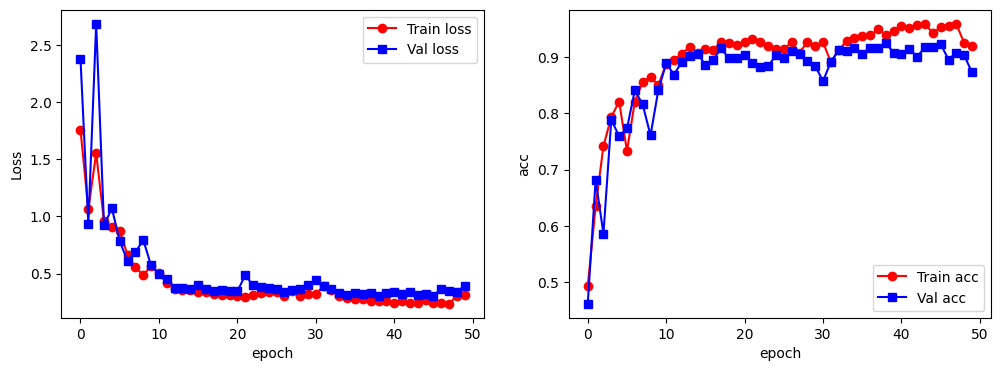

In [10]:
# search pamp to find the differences and change
num_classes = 12 #pamp2 =12 wisdm =6
inchannels = 3 #pamp2 =36 wisdm =3

#1
#model_n_casa = resnest_t(inchannels=inchannels,num_classes=num_classes,block = ResNeStBottleneck_WithoutCASA)
#2
#model_n_ca = resnest_t(inchannels=inchannels,num_classes=num_classes,block = ResNeStBottleneck_WithoutCA)
#3
#model_n_sa = resnest_t(inchannels=inchannels,num_classes=num_classes,block = ResNeStBottleneck_WithoutSA)
#4
model = resnest_t(inchannels=inchannels,num_classes=num_classes,block = ResNeStBottleneck)

model = model
if __name__ == '__main__':
    # 加载需要的模型
    
    # 加载数据集
    train_data, val_data = train_val_data_process()
    # 利用现有的模型进行模型的训练
      # 替换为你的类别总数
    beta = 1  # 平衡系数  #wisdm
    #beta=0.8  #pamp2
    #weights = [0.1, 0.8,0.1] #wisdm
    a=0.45
    weights = [0.25, 0.5,0.25] #pamp2
    #4
    criterion1 = nn.CrossEntropyLoss()
    #5
    criterion2 = MultiLoss_Withoutweight(num_classes, beta, weights)
    #不测
    criterion3 = MultiLoss(num_classes, beta, weights,smoothing=0.1)#smoothing=0.15  #pamp2

    train_process = train_model_process(model, train_data,val_data, num_epochs=50,criterion = criterion3)
    matplot_acc_loss(train_process)

In [11]:
torch.save(model, 'res_pamap2100_model.pt')

In [12]:
import torch

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch.nn as nn


def test_final(model, test_dataloader):
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    criterion1 = nn.CrossEntropyLoss()
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  

    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=range(num_classes))

    report = classification_report(y_true, y_pred,digits=4)
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    g_mean = np.sqrt(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    g_mean = np.mean(g_mean)
    report += '\nG-mean: {:.4f}'.format(g_mean)
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%, G-mean: {:.4f}'.format(test_loss, test_acc, g_mean))
    print(report)


def test_data_process():
    test_data = CustomDataset(x_test_path, y_test_path)
    test_dataloader = DataLoader(test_data, batch_size=pamp2_b, shuffle=True, num_workers=2)
    return test_dataloader


def test_model_process(model, test_dataloader):
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    classes = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

    test_corrects = 0.0
    test_num = 0

    with torch.no_grad():
        for test_data_x, test_data_y in test_dataloader:
            test_data_x = test_data_x.to(device)
            test_data_y = test_data_y.to(device)
            model.eval()
            output = model(test_data_x)
            pre_lab = torch.argmax(output, dim=1)
            test_corrects += torch.sum(pre_lab == test_data_y.data)
            test_num += test_data_x.size(0)

    test_acc = test_corrects.double().item() / test_num
    print("测试的准确率为：", test_acc)



if __name__ == "__main__":
    model = torch.load('res_pamap2100_model.pt')
    test_dataloader = test_data_process()
    test_final(model, test_dataloader)
  


Test Loss: 1.1282, Test Acc: 72.10%, G-mean: 0.8048
              precision    recall  f1-score   support

           0     0.0323    0.0110    0.0164        91
           1     0.4226    0.6827    0.5221       104
           2     0.6250    0.8235    0.7107        85
           3     0.7986    0.8952    0.8441       124
           4     0.9278    0.9474    0.9375        95
           5     0.9189    0.7158    0.8047        95
           6     0.9009    0.9804    0.9390       102
           7     0.7059    0.4364    0.5393        55
           8     0.8163    0.8333    0.8247        48
           9     0.9206    0.6170    0.7389        94
          10     0.6867    0.8047    0.7410       128
          11     0.9545    0.7241    0.8235        29

    accuracy                         0.7210      1050
   macro avg     0.7258    0.7060    0.7035      1050
weighted avg     0.7109    0.7210    0.7044      1050

G-mean: 0.8048
